In [113]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("../project1-partA/project1_data.csv")
df.head()

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,Market_Value
0,2014-01-02,76.27,76.04,76.500,75.90,5212460.0,134027.7199,DIS,1.022229e+07
1,2014-01-03,76.11,76.30,76.697,76.01,4061042.0,133746.5552,DIS,1.017945e+07
2,2014-01-06,75.82,76.53,76.840,75.49,6816693.0,133236.9441,DIS,1.010203e+07
3,2014-01-07,76.34,76.12,76.700,75.90,4511157.0,134150.7295,DIS,1.024107e+07
4,2014-01-08,75.22,76.13,76.280,74.81,10914858.0,132182.5763,DIS,9.942773e+06


In [114]:
n_tickers = len(df["Ticker"].unique())

df['Date'] = pd.to_datetime(df['Date'])

# Column called total market value that is the total market value per day
df["Total_Market_Value_Day"] = df.groupby('Date')['Market_Value'].transform("sum")

# Value Weight column
df["Value_Weight"] = df["Market_Value"] / df["Total_Market_Value_Day"]

# Equal Weight column
df["Equal_Weight"] = 1 / n_tickers

In [115]:
# Calculating daily return of the stocks
df["Daily_Return"] = (df["PX_LAST"] - df["PX_OPEN"]) / df["PX_OPEN"]

In [117]:
import time
from datetime import datetime
specific_date = "2014-03-06"

def pie_chart_for_specific_date(df,date):
    df_for_pie = df[df["Date"]==date]
    fig = px.pie(df_for_pie, values='Value_Weight', names='Ticker', title=f'Value-Weighted of portfolio in {date}',width=600)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()
    
pie_chart_for_specific_date(df,specific_date)

In [118]:
df

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,Market_Value,Total_Market_Value_Day,Value_Weight,Equal_Weight,Daily_Return
0,2014-01-02,76.27,76.04,76.500,75.900,5212460.0,134027.7199,DIS,1.022229e+07,4.859792e+07,0.210344,0.033333,0.003025
1,2014-01-03,76.11,76.30,76.697,76.010,4061042.0,133746.5552,DIS,1.017945e+07,4.840901e+07,0.210280,0.033333,-0.002490
2,2014-01-06,75.82,76.53,76.840,75.490,6816693.0,133236.9441,DIS,1.010203e+07,4.849603e+07,0.208306,0.033333,-0.009277
3,2014-01-07,76.34,76.12,76.700,75.900,4511157.0,134150.7295,DIS,1.024107e+07,4.965378e+07,0.206249,0.033333,0.002890
4,2014-01-08,75.22,76.13,76.280,74.810,10914858.0,132182.5763,DIS,9.942773e+06,4.934948e+07,0.201477,0.033333,-0.011953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75167,2024-08-06,54.08,52.93,55.110,52.659,16405667.0,74061.2621,CMG,4.005233e+06,5.450343e+08,0.007349,0.033333,0.021727
75168,2024-08-07,53.63,54.50,55.300,53.410,11238844.0,73444.9979,CMG,3.938855e+06,5.320586e+08,0.007403,0.033333,-0.015963
75169,2024-08-08,54.32,54.00,54.890,53.740,9305774.0,74389.9363,CMG,4.040861e+06,5.535762e+08,0.007300,0.033333,0.005926
75170,2024-08-09,55.55,54.90,56.140,54.530,11569747.0,76074.3918,CMG,4.225932e+06,5.601571e+08,0.007544,0.033333,0.011840


In [119]:
# Rebalance these portfolios in the first day of the month based on the information on the last day (1-day lag)
# For example the day 2014-01-31 and 2014-02-03 now have the same Value_Weight
tickers = df["Ticker"].unique()
list_of_df_tik = []
for tik in tickers:
    df_tik = df.loc[df["Ticker"]==tik,:]
    df_tik.set_index("Date",inplace=True)
    last_day_prev_month = df_tik['Value_Weight'].resample('M').last()
    first_day_curr_month = df_tik.groupby([df_tik.index.year, df_tik.index.month]).head(1)
    last_day_prev_month_list = last_day_prev_month.to_list()
    last_day_prev_month_list.insert(0,first_day_curr_month["Value_Weight"][0])
    last_day_prev_month_list.pop(-1)
    first_day_curr_month.loc[:,"Value_Weight"] = last_day_prev_month_list
    mask = df_tik.index.isin(first_day_curr_month.index)
    df_tik.loc[mask, 'Value_Weight'] = first_day_curr_month
    df_tik.reset_index(inplace=True)
    list_of_df_tik.append(df_tik)

In [120]:
new_df = pd.concat(list_of_df_tik)
new_df

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,Market_Value,Total_Market_Value_Day,Value_Weight,Equal_Weight,Daily_Return
0,2014-01-02,76.27,76.04,76.500,75.900,5212460.0,134027.7199,DIS,1.022229e+07,4.859792e+07,0.210344,0.033333,0.003025
1,2014-01-03,76.11,76.30,76.697,76.010,4061042.0,133746.5552,DIS,1.017945e+07,4.840901e+07,0.210280,0.033333,-0.002490
2,2014-01-06,75.82,76.53,76.840,75.490,6816693.0,133236.9441,DIS,1.010203e+07,4.849603e+07,0.208306,0.033333,-0.009277
3,2014-01-07,76.34,76.12,76.700,75.900,4511157.0,134150.7295,DIS,1.024107e+07,4.965378e+07,0.206249,0.033333,0.002890
4,2014-01-08,75.22,76.13,76.280,74.810,10914858.0,132182.5763,DIS,9.942773e+06,4.934948e+07,0.201477,0.033333,-0.011953
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2024-08-06,54.08,52.93,55.110,52.659,16405667.0,74061.2621,CMG,4.005233e+06,5.450343e+08,0.007349,0.033333,0.021727
2666,2024-08-07,53.63,54.50,55.300,53.410,11238844.0,73444.9979,CMG,3.938855e+06,5.320586e+08,0.007403,0.033333,-0.015963
2667,2024-08-08,54.32,54.00,54.890,53.740,9305774.0,74389.9363,CMG,4.040861e+06,5.535762e+08,0.007300,0.033333,0.005926
2668,2024-08-09,55.55,54.90,56.140,54.530,11569747.0,76074.3918,CMG,4.225932e+06,5.601571e+08,0.007544,0.033333,0.011840


In [121]:
new_df["Value_Weight*Daily_Return"] = new_df["Value_Weight"]*new_df["Daily_Return"]
new_df["Equal_Weight*Daily_Return"] = new_df["Equal_Weight"]*new_df["Daily_Return"]

In [122]:
value_weighted_return = new_df.groupby("Date")["Value_Weight*Daily_Return"].sum()

equal_weighted_return = new_df.groupby("Date")["Equal_Weight*Daily_Return"].sum()

portfolios = pd.DataFrame({
    "Daily_Return_with_Value_Weighted_Portfolio": value_weighted_return,
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weighted_return
})

portfolios.reset_index(inplace=True)
portfolios

,Date,Daily_Return_with_Value_Weighted_Portfolio,Daily_Return_with_Equal_Weighted_Portfolio
0,2014-01-02,-0.003324,-0.004958
1,2014-01-03,-0.003096,0.002189
2,2014-01-06,-0.003736,-0.003695
3,2014-01-07,0.006103,0.003307
4,2014-01-08,-0.002151,0.003586
...,...,...,...
2665,2024-08-06,-0.002248,0.005482
2666,2024-08-07,-0.020181,-0.019729
2667,2024-08-08,0.011787,0.015819
2668,2024-08-09,0.014371,0.002092


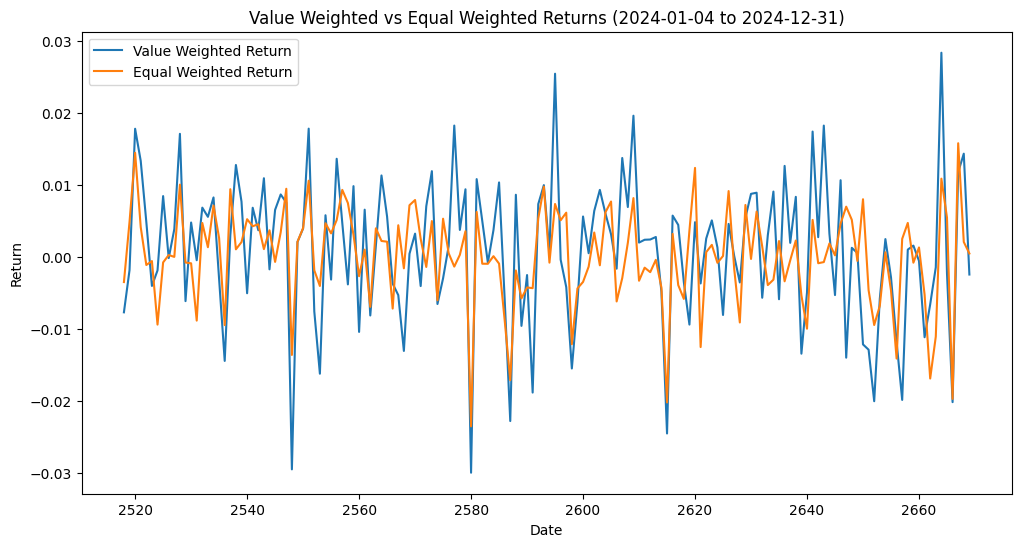

In [123]:
import matplotlib.pyplot as plt

# Define the date range (adjust the dates to your specific needs)
start_date = "2024-01-04"
end_date = "2024-12-31"

filtered_df = portfolios[(portfolios["Date"] >= start_date) & (portfolios["Date"] <= end_date)]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df.index, filtered_df["Daily_Return_with_Value_Weighted_Portfolio"], label="Value Weighted Return")
plt.plot(filtered_df.index, filtered_df["Daily_Return_with_Equal_Weighted_Portfolio"], label="Equal Weighted Return")

plt.title(f"Value Weighted vs Equal Weighted Returns ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

plt.show()

In [124]:
# Compute annualized average return
annualized_average_return =portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio"]].mean()
annualized_average_return

,Daily_Return_with_Value_Weighted_Portfolio,Daily_Return_with_Equal_Weighted_Portfolio
Date,,
2014,-0.000207,0.000129
2015,0.000017,0.000083
2016,0.000300,0.000711
2017,0.000354,0.000207
2018,-0.000490,-0.000513
2019,0.000494,0.000562
2020,0.000680,-0.000226
2021,0.000424,0.000361
2022,-0.000377,0.000271


In [125]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Value_Weighted_Portfolio","Daily_Return_with_Equal_Weighted_Portfolio"]].std()
standard_deviation_return

,Daily_Return_with_Value_Weighted_Portfolio,Daily_Return_with_Equal_Weighted_Portfolio
Date,,
2014,0.007647,0.006874
2015,0.008419,0.007704
2016,0.007129,0.007798
2017,0.004038,0.003922
2018,0.011319,0.009192
2019,0.006691,0.006043
2020,0.014052,0.014706
2021,0.008453,0.007624
2022,0.015787,0.012735


In [149]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_rate = 0.04

# VWP = Value-Weighted Portfolio
# EWP = Equal-Weighted Portfolio
annualized_average_return["Excess_Return_VWP"] = annualized_average_return["Daily_Return_with_Value_Weighted_Portfolio"] - risk_free_rate
annualized_average_return["Excess_Return_EWP"] = annualized_average_return["Daily_Return_with_Equal_Weighted_Portfolio"] - risk_free_rate
risk_premium_VWP = annualized_average_return["Excess_Return_VWP"].mean()
risk_premium_EWP = annualized_average_return["Excess_Return_EWP"].mean()

# Get the Squared deviations from mean (Risk premium in each port)
annualized_average_return["Squared_Deviations_From_Mean_VWP"] = (annualized_average_return["Excess_Return_VWP"] - risk_premium_VWP)**2
annualized_average_return["Squared_Deviations_From_Mean_EWP"] = (annualized_average_return["Excess_Return_EWP"] - risk_premium_EWP)**2

# Get the standard deviation from mean (Risk premium in each port)
SD_Excess_Return_VWP = annualized_average_return["Squared_Deviations_From_Mean_VWP"].std()
SD_Excess_Return_EWP = annualized_average_return["Squared_Deviations_From_Mean_EWP"].std()
print("Risk Premium for the Value Weighted Portfolio",risk_premium_VWP)
print("Risk Premium for the Equal Weighted Portfolio",risk_premium_EWP)


if risk_premium_VWP<0:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Value Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")

if risk_premium_EWP<0:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% less from investing in this portfolio than from investing in the risk free security.")
else:
    print(f"With the Equal Weighted Portfolio, you should expect to get {abs(risk_premium_VWP)*100:.2f}% more from investing in this portfolio than from investing in the risk free security.")

Risk Premium for the Value Weighted Portfolio -0.039652733216011336
Risk Premium for the Equal Weighted Portfolio -0.03978699909728018
With the Value Weighted Portfolio, you should expect to get 3.97% less from investing in this portfolio than from investing in the risk free security.
With the Equal Weighted Portfolio, you should expect to get 3.97% less from investing in this portfolio than from investing in the risk free security.


In [150]:
sharpe_ratio_VWP = risk_premium_VWP / SD_Excess_Return_VWP
sharpe_ratio_EWP = risk_premium_VWP / SD_Excess_Return_EWP

print("Sharpe ratio value-weighted portfolio: ",sharpe_ratio_VWP)
print("Sharpe ratio equal-weighted portfolio: ",sharpe_ratio_EWP)

Sharpe ratio value-weighted portfolio:  -77687.47730063884
Sharpe ratio equal-weighted portfolio:  -242867.60916158123


# Conclusion: The model is very bad!

Plot cumulative returns for both porfolios, S&P 500 and risk-free

In [191]:
# returns = portfolios.copy()

# returns["Daily_Return_with_Risk_Free_Asset"] = risk_free_rate / 365
returns_per_year = pd.DataFrame()
returns_per_year["Annually_Return_VWP"] = annualized_average_return["Daily_Return_with_Value_Weighted_Portfolio"]
returns_per_year["Annually_Return_EWP"] = annualized_average_return["Daily_Return_with_Equal_Weighted_Portfolio"]
returns_per_year["Annually_Return_with_Risk_Free_Asset"] = risk_free_rate

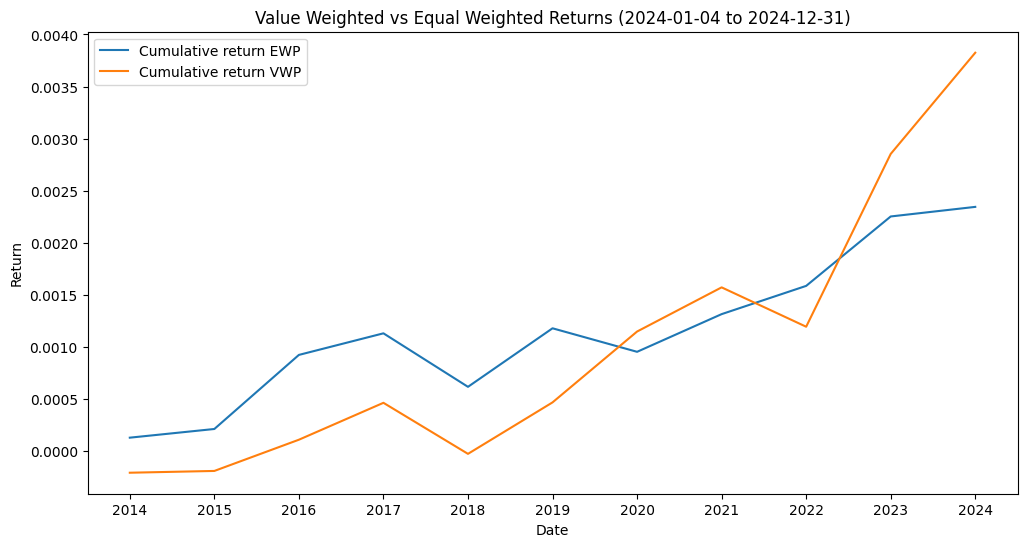

In [193]:
cumulative_returns_EWP = (returns_per_year["Annually_Return_EWP"]+1).cumprod() - 1
cumulative_returns_VWP = (returns_per_year["Annually_Return_VWP"]+1).cumprod() - 1
cumulative_returns_RiskFree = (returns_per_year["Annually_Return_with_Risk_Free_Asset"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(returns_per_year.index, cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(returns_per_year.index, cumulative_returns_VWP, label="Cumulative return VWP")
# plt.plot(returns_per_year.index, cumulative_returns_RiskFree, label="Cumulative return Risk-Free")

plt.title(f"Value Weighted vs Equal Weighted Returns ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()